In [6]:
import profile

In [20]:
%matplotlib inline
from scipy.misc import comb
from itertools import combinations
import scipy.constants
import matplotlib.pyplot as plt
import numpy.matlib
import numpy
import numpy.linalg
import numpy.random
from qutip import *
import numpy as np
from scipy.constants import epsilon_0, pi
from sklearn.preprocessing import normalize
settings.auto_tidyup = False # This is essential when working in SI units

debye=3.33564e-30
eV = scipy.constants.e
nm = 1e-9

# in gs, the bigger index goes first!
def dickeH(K=2, omega=1., epsilons=1., Vs=0, gs=0, bdim=3):
    """Build the generalized extended Dicke Hamiltonian with
    K atoms, with the field Fock space truncated to bdim
    
    TODO doc
    """
    if (isinstance(epsilons, int) or isinstance(epsilons, float)):
        epsilons = [epsilons] * K
    if (isinstance(Vs, int) or isinstance(Vs, float)):
        Vs = [Vs] * K
    if (isinstance(gs, int) or isinstance(gs, float)):
        g = gs
        gs = []
        for j in range(K):
            gs.append([g] * j)
    sz=[]
    sp=[]
    sm=[]
    eye = tensor(K*[qeye(2)]+[qeye(bdim)])
    for i in range(K):
        sz.append(tensor(i*[qeye(2)]+[sigmaz()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
        sp.append(tensor(i*[qeye(2)]+[sigmap()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
        sm.append(tensor(i*[qeye(2)]+[sigmam()]+(K-i-1)*[qeye(2)]+[qeye(bdim)]))
    bcr=tensor(K*[qeye(2)]+[create(bdim)])
    ban=tensor(K*[qeye(2)]+[destroy(bdim)])
    bnum=tensor(K*[qeye(2)]+[num(bdim)])
    H=sz[0]-sz[0] # Neumim jinak udělat nulu
    for i in range(K):
        #H += epsilons[i] * sz[i]  
        H += epsilons[i] * (sz[i] + eye)/2.
        H += Vs[i]*(bcr*sm[i] + sp[i]*ban)
    for i in range(K):
        for j in range(i):
            H += gs[i][j] * (sp[i]*sm[j] + sp[j]*sm[i])
    H += omega * bnum
    return H

# N.B. here, n is ascending in the matrices, whereas in the text it is
# descending.

def ddim(K, tau):
    if (tau >= K):
        return 2**K
    d = 0
    for k in range(tau + 1):
        d += comb(K, k, True)
    return d
   

def i2n(i, K, tau):
    """Mapping between integers and bosonic excitation numbers.
    
    Returns the bosonic excitation number n, corresponding to the state
    with the index i (described in i2c)...
    """
    n = max(0, tau - K)
    base = 0
    nxt = comb(K, tau - n, True)
    while (i >= nxt):
        n += 1
        base = nxt
        nxt += comb(K, tau - n, True)
        if (base == nxt):
            print "i2n(",i,",",K,",",tau,"): invalid argument"
            return None
    return n


def i2m(i, K, tau):
    """Mapping between integers and lists of excited atoms.
    
    Returns a list m of excited atoms in the state (n,m),
    which is the i-th such state from the subspace with
    K atoms and total excitation number tau, in lexicographic
    order.
    
    The lowest possible i is 0.
    """
    #The whole code deserves some dynamic approach
    #determine atomic excitation number (tau - n)
    n = max(0, tau - K)
    base = 0
    nxt = comb(K, tau - n, True)
    while (i >= nxt):
        n += 1
        base = nxt
        nxt += comb(K, tau - n, True)
        if (base == nxt):
            print "i2m(",i,",",K,",",tau,"): invalid argument"
            return None
    # generate the combinations
    j = base
    for m in combinations(range(K), tau - n):
        if (j == i):
            return m
        j += 1
    raise
    
def i2nm(i, K, tau):
    return (i2n(i, K, tau), i2m(i, K, tau))

def nm2i(n, m, K):
    """Mapping excitation combinations to integer index."""
    m = tuple(sorted(m))
    tau = len(m) + n
    base = 0
    for nn in range(max(0,tau - K), n):
        base += comb(K, tau - nn, True)
    i = base
    for mm in combinations(range(K), len(m)):
        if(m == mm):
            return i
        else:
            i += 1
    else:
        raise
        
def tau_projector(K, tau, bdim):
    """Returns a matrix which restricts dickeH Hamiltonian to a single excitation subspace."""
    # TODO kontrola bdim vs tau
    newdim = ddim(K, tau)
    vects = []
    for i in range(newdim):
        n, m = i2nm(i, K, tau) 
        setm = set(m)
        vect = []
        for j in range(K):
            vect.append(basis(2, 1-(j in setm))) # 0 is up, 1 is down
        vect.append(basis(bdim, n))
        vects.append(tensor(vect).full())
    return array(vects).squeeze(axis=2)  
        
    
def dickeH_proj(K=2, omega=1., epsilons=1., Vs=0, gs=0, tau=1):
    """Like dickeH, but restricted to a constant excitation number tau."""
    bdim = tau + 1
    proj = tau_projector(K, tau, bdim)
    H = dickeH(K=K, omega=omega, epsilons=epsilons, Vs=Vs, gs=gs, bdim=bdim)
    return np.dot(np.dot(proj , H.full()), proj.transpose())
    
def randomPositionBox(K=10, x=10*nm, y=10*nm, z=5*nm):
    return numpy.random.rand(K, 3) * numpy.array([x,y,z])

def randomUnitVectors(K=10):
    return normalize(numpy.random.randn(K, 3), axis=1, norm='l2')

def dipoleCouplings(K=10, positions=randomPositionBox(), directions=0, mu = 2*debye):
    if (directions is 0):
        directions = randomUnitVectors(K)
    epsilon_0 = scipy.constants.epsilon_0
    #TODO parameter units
    #TODO split the function to have the position/direction generation extra
    #(thus making it available for plotting etc.)
    gs = []
    for i in range(K):
        pos1 = positions[i]        
        dir1 = directions[i]        
        gline = []        
        for j in range(i):
            pos2 = positions[j]
            dir2 = directions[j]
            rv = pos2 - pos1
            r = numpy.linalg.norm(rv)
            V = numpy.dot(dir1, dir2) - 3 * numpy.dot(dir1, rv) * numpy.dot(dir2, rv) / r**2
            V *= mu**2 / (4 * pi * epsilon_0 * r**3)
            gline.append(V)
        gs.append(gline)
    return gs

def dipoleFieldCouplings(K=10, magnitude=0.1*eV, directions=0, fieldDir=numpy.array([1,0,0])):
    if (directions is 0):
        directions = randomUnitVectors(K)
    Vs = []
    fieldDir = normalize(fieldDir)
    for i in range(K):
        d = normalize(directions[i])
        Vs.append(magnitude * numpy.dot(d, fieldDir))
    return Vs

In [21]:
def lrange(start,stop,stepcount):
    l  = []
    val = start
    step = float(stop - start) / stepcount
    while (val <= stop):
        l.append(val)
        val += step
    return l

def dicke_tryparams(K=2, bdim=3, start=2.21, stop=3, 
                    epsilons=2.6, Vs=0.26, gs=0):
    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = dickeH(K=K,bdim=bdim,epsilons=epsilons,omega=om, Vs=Vs, gs=gs)
        eiglist.append(H.eigenenergies())
 
    plt.figure(figsize=(10,6),dpi=200)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega$')
    plt.ylabel('$E$')
    
def dicke_tryparams_proj(K=2, tau=1, start=2.21, stop=3, 
                    epsilons=2.6, Vs=0.26, gs=0):
    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = dickeH_proj(K=K,tau=tau,epsilons=epsilons,omega=om, Vs=Vs, gs=gs)
        eiglist.append(numpy.linalg.eigvalsh(H))
 
    plt.figure(figsize=(10,6),dpi=200)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega$')
    plt.ylabel('$E$')
    
    
    
# N. B. the following expects input in SI units
def randomBox_tryparams(K=20, bdim=3, x=5*nm, y=5*nm, z=3*nm, mu=2*debye,
                        start=2.21*eV, stop=3*eV,
                        epsilons=2.6*eV, Vs=0.1*eV):
    dirs = randomUnitVectors(K)
    pos = randomPositionBox(K=K,x=x,y=y,z=z)
    gs = dipoleCouplings(K, pos, dirs, mu)
#    print gs
    
    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = dickeH(K=K,bdim=bdim,epsilons=epsilons,omega=om, Vs=Vs, gs=gs)
        eigs=H.eigenenergies()#eigvals=0*(K+4))
#        np.delete(eigs,0)
        eiglist.append(eigs)
    for i in range(len(omegalist)):
        omegalist[i] /= eV
        eiglist[i] /= eV
        
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega/\mathrm{eV}$')
    plt.ylabel('$E/\mathrm{eV}$')
    
def randomBox_tryparams_tau(K=20, tau=1, x=5*nm, y=5*nm, z=3*nm, mu=2*debye,
                        start=2.21*eV, stop=3*eV,
                        epsilons=2.6*eV, Vs=0.1*eV):
    dirs = randomUnitVectors(K)
    pos = randomPositionBox(K=K,x=x,y=y,z=z)
    gs = dipoleCouplings(K, pos, dirs, mu)
    print gs
    
    musterH = dickeH_proj(K=K,tau=tau,epsilons=epsilons,omega=0, Vs=Vs, gs=gs)
    omegaMuster = dickeH_proj(K=K, tau=tau, epsilons=0, omega=1, Vs=0, gs=0)

    omegalist = lrange(start, stop, 50)
    eiglist = []
    for om in omegalist:
        H = musterH + om * omegaMuster
        eigs=numpy.linalg.eigvalsh(H)
        eiglist.append(eigs)
    for i in range(len(omegalist)):
        omegalist[i] /= eV
        eiglist[i] /= eV
        
    plt.figure(figsize=(10,6),dpi=100)
    plt.plot(omegalist, eiglist)
    plt.xlabel('$\omega/\mathrm{eV}$')
    plt.ylabel('$E/\mathrm{eV}$')

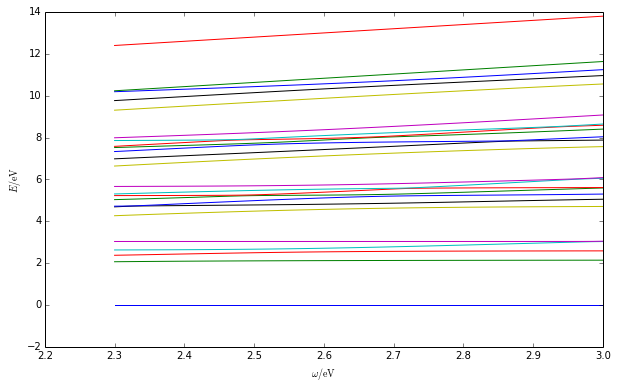

In [22]:
randomBox_tryparams(K=3, x=0.1*nm, y=0.1*nm, z=1*nm,Vs=0.1*eV, start=2.3*eV, stop=3*eV,mu=2*debye, bdim=3)

[[], [-1.2005723803597491e-22], [-6.082386482151784e-24, 1.1220124245433728e-23], [-4.8579665459153752e-24, -1.371237742275022e-23, 6.8380471354908834e-24], [2.8495124336228966e-23, -6.1378835130591004e-23, 3.9576551540301831e-23, -4.399029305764886e-25], [-2.9979744112630161e-24, 8.5785397402972354e-24, 2.4392307668569342e-23, 7.6213670544844511e-24, -5.4468674253958613e-25], [9.5301795850696145e-25, -3.7724296684266837e-24, -2.3099705443685951e-20, -2.488597097326658e-24, 3.065541899872812e-23, -2.6718143876249161e-23], [4.8923114243289931e-24, -2.3831102106191957e-23, -1.4629941283561442e-24, -1.4715031730029365e-24, 2.9351976573309957e-24, 3.5681646903287859e-26, -3.7000990808471036e-24], [3.1557397767282466e-24, -8.3651320641788815e-24, -2.4993596499501896e-24, -2.8033730538110978e-24, -9.1913060041826331e-24, -1.2742643706170146e-24, -3.1499008522592775e-24, 2.028158979304623e-24], [4.2391842474561227e-24, -6.5726889303242743e-24, 3.0778863857233397e-24, 4.4642365662718556e-24, -

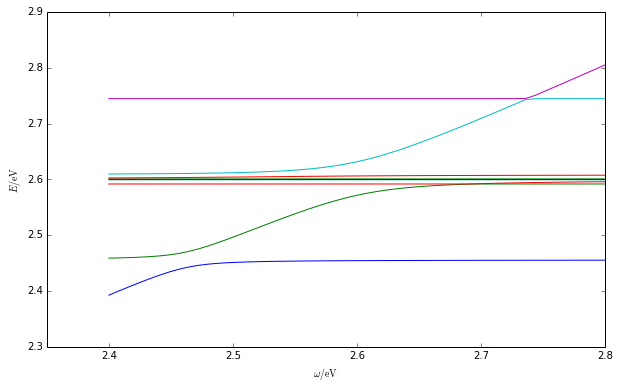

In [26]:
K=11
a=2*nm*K**(1./3)
randomBox_tryparams_tau(K=K, x=a, y=a, z=a, epsilons=2.6*eV,Vs=0.01*eV, start=2.4*eV, stop=2.8*eV,mu=2*debye, tau=1)

In [9]:
gs=dipoleCouplings(K=6, mu=20*debye)

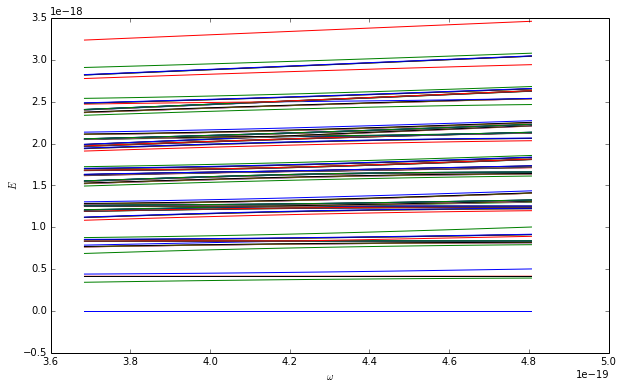

In [10]:
dicke_tryparams(K=6, epsilons=2.6*eV,Vs=0.11*eV, start=2.3*eV, stop=3*eV,gs=gs, bdim=3)

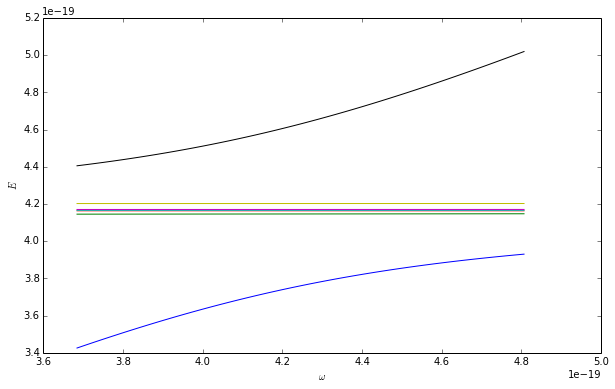

In [11]:
dicke_tryparams_proj(K=6, epsilons=2.6*eV,Vs=0.11*eV, start=2.3*eV, stop=3*eV,gs=gs, tau=2)

In [ ]:
def dickeH_proj(K=2, omega=1., epsilons=1., Vs=0, gs=0, tau=1):
    """Like dickeH, but restricted to a constant excitation number tau."""
    bdim = tau + 2
    proj = tau_projector(K, tau, bdim)
    H = dickeH(K=K, omega=omega, epsilons=epsilons, Vs=Vs, gs=gs, bdim=bdim)
    return np.dot(np.dot(proj , H.full()), proj.transpose())

dicke_tryparams_proj(K=6, epsilons=2.6*eV,Vs=0.11*eV, start=2.3*eV, stop=3*eV,gs=gs, tau=2)

In [ ]:
def dickeH_proj(K=2, omega=1., epsilons=1., Vs=0, gs=0, tau=1):
    """Like dickeH, but restricted to a constant excitation number tau."""
    bdim = tau + 1
    proj = tau_projector(K, tau, bdim)
    H = dickeH(K=K, omega=omega, epsilons=epsilons, Vs=Vs, gs=gs, bdim=bdim)
    return np.dot(np.dot(proj , H.full()), proj.transpose())

dicke_tryparams_proj(K=6, epsilons=2.6*eV,Vs=0.11*eV, start=2.3*eV, stop=3*eV,gs=gs, tau=2)